In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Save the train and test DataFrames
X_TRAIN_DIR = "processed_data/glcm/X_train.pkl"
y_TRAIN_DIR = "processed_data/glcm/y_train.pkl"
X_TEST_DIR = "processed_data/glcm/X_test.pkl"
y_TEST_DIR = "processed_data/glcm/y_test.pkl"

X_train = pd.read_pickle(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4129, 67)
(4129,)
(1030, 67)
(1030,)


Explained Variance Ratios: [0.47369472 0.22187318 0.15526852 0.04734416 0.02415634 0.01952849
 0.0145262  0.01318494 0.00920865 0.00539288]
Cumulative Explained Variance Ratios: [0.47369472 0.6955679  0.85083641 0.89818058 0.92233692 0.94186541
 0.9563916  0.96957654 0.9787852  0.98417807]


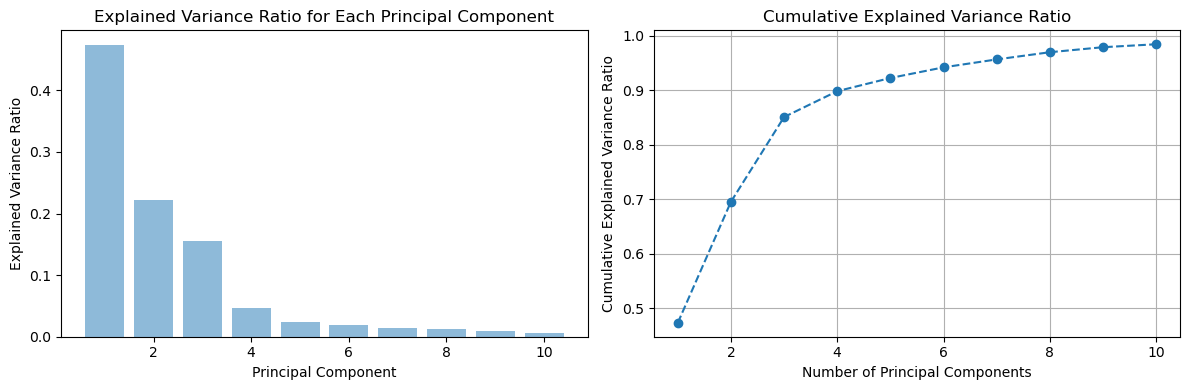

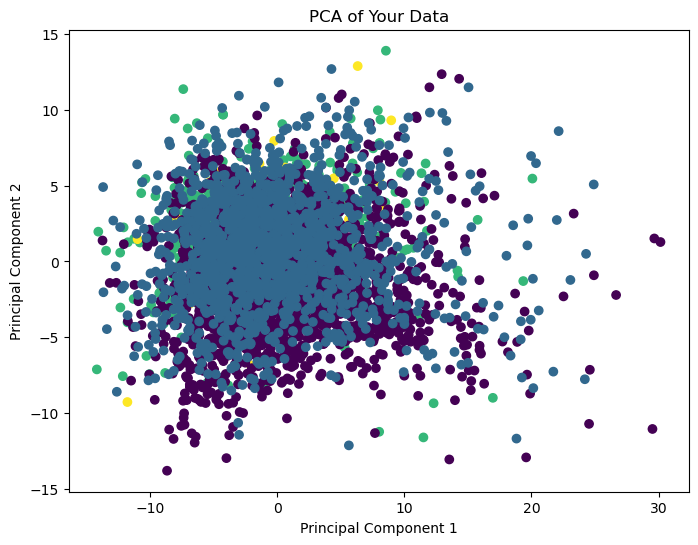

In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate the features (X) and the target variable (y) if applicable
X = X_train
y = y_train

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform PCA
n_components = 10  # Choose the number of principal components to retain (first 10)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_std)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Visualize the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("Explained Variance Ratios:", explained_variance_ratio)
print("Cumulative Explained Variance Ratios:", cumulative_variance_ratio)

# Plot the explained variance ratio
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance Ratio for Each Principal Component')

# Plot the cumulative explained variance ratio
plt.subplot(1, 2, 2)
plt.plot(range(1, n_components + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid()
plt.tight_layout()

# You can also visualize the data in the new PCA space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Your Data')
plt.show()


In [24]:
# Transform your data into the first 4 principal components
X_pca_4 = pca.transform(X_std)[:, :4]

# Create a DataFrame with the first 4 principal components
X_train_PCA = pd.DataFrame(data=X_pca_4, columns=[f'PC{i+1}' for i in range(4)])


# Standardize the testing data using the same scaler used for training data
X_test_std = scaler.transform(X_test)

# Transform the testing data into the first 4 principal components using the existing PCA model
X_test_pca_4 = pca.transform(X_test_std)[:, :4]

# Create a DataFrame with the first 4 principal components for the testing data
X_test_PCA = pd.DataFrame(data=X_test_pca_4, columns=[f'PC{i+1}' for i in range(4)])


In [16]:
def xgboost_classification(X_train, y_train, X_test, y_test):
    """
    Perform XGBoost multiclass classification, evaluate the model, and create a confusion matrix.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.

    Returns:
    None
    """
    
    # Create a label encoder
    label_encoder = LabelEncoder()
    
    # Encode the class labels
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Inverse transform for class labels in the confusion matrix
    class_labels = label_encoder.classes_
    
    # Create a DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
    dtest = xgb.DMatrix(X_test)

    # Define parameters for the XGBoost model
    params = {
        'objective': 'multi:softprob',  # Multiclass classification
        'num_class': len(class_labels),  # Number of classes
        'max_depth': 6,  # Maximum depth of trees
        'eta': 0.3,  # Learning rate
    }


    num_round = 100  # Number of boosting rounds

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_round)

    # Predict labels
    y_pred_prob = model.predict(dtest)
    y_pred = [class_labels[idx] for idx in np.argmax(y_pred_prob, axis=1)]  # Convert probabilities to class labels

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    

c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c

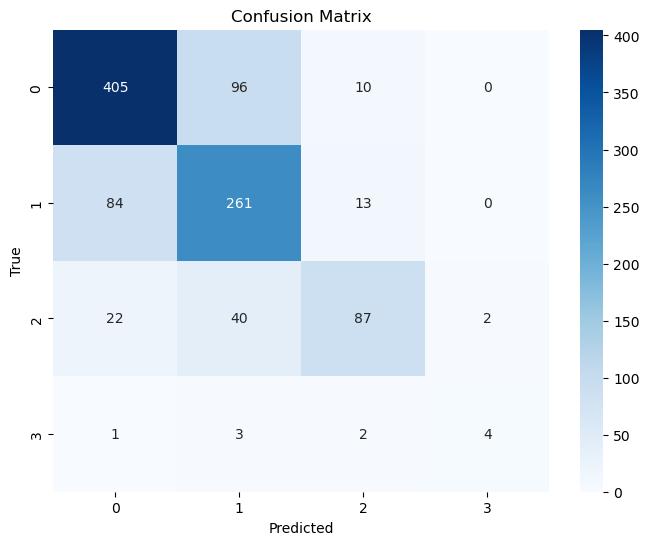

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       511
           1       0.65      0.73      0.69       358
           2       0.78      0.58      0.66       151
           3       0.67      0.40      0.50        10

    accuracy                           0.73      1030
   macro avg       0.72      0.62      0.66      1030
weighted avg       0.74      0.73      0.73      1030



In [19]:
# Call the xgboost_classification function with your data
xgboost_classification(X_train_PCA, y_train, X_test_PCA, y_test)

c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c

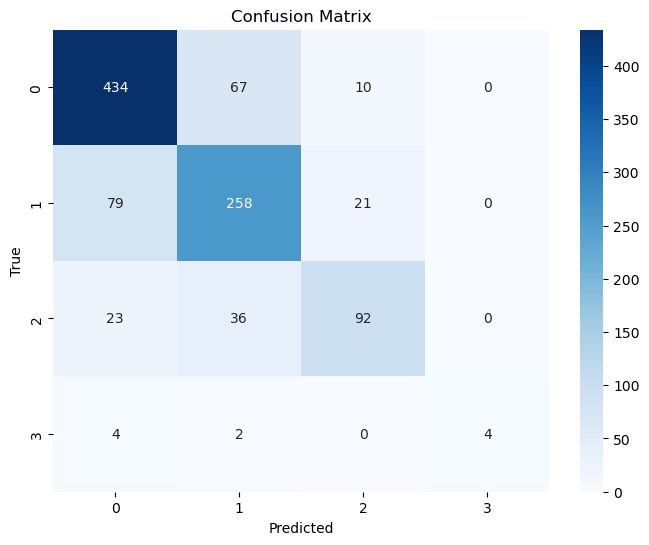

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       511
           1       0.71      0.72      0.72       358
           2       0.75      0.61      0.67       151
           3       1.00      0.40      0.57        10

    accuracy                           0.77      1030
   macro avg       0.82      0.64      0.70      1030
weighted avg       0.77      0.77      0.76      1030



In [26]:
# Call the xgboost_classification function with your data
xgboost_classification(X_train, y_train, X_test, y_test)